In [1]:
from smartem import smartem,tools
from smartem.online import microscope,get_rescan_maps
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.offline.train_mb_error_detector.tools import get_error_GT, VI
from smartem.online.models import UNet as UNet_online
from smartem.segmentation import segmenter, utils
import h5py
import numpy as np
from skimage import io, measure, segmentation
from pathlib import Path
import matplotlib.pyplot as plt
import pyvoi
import seaborn as sns
import pandas as pd
from tqdm import tqdm 
import torch
import os
import scipy.ndimage as ndi

In [2]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
temp_dir = "/storage2/projects/smartEM/em-vis/new_temp/"

device = torch.device("cuda:0")

em2mb_model_us = UNet_offline.UNet(1,2)
em2mb_model_core = UNet_online.UNet(1,2)
em2mb_path_us = "../../pretrained_models/em2mb_best.pth"
errnet_path_us = "../../pretrained_models/error_best.pth"
em2mb_path_core = "../../pretrained_models_core/em2mb_best.pth"
errnet_path_core = "../../pretrained_models_core/error_best.pth"

fast_dwt = 50
slow_dwt = 800
rescan_ratios = [0, 0.05, 0.1, 0.25, 0.5, 1.0]
valid_dwts = [25, 50, 75, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200]

In [3]:
Iseg_us = segmenter.Segmenter(em2mb_path_us, segmenter_function = measure.label, device=device)
Iseg_us.set_model(model_class=em2mb_model_us)

Iseg_core = segmenter.Segmenter(em2mb_path_core, segmenter_function = segmentation.watershed, device=device)
Iseg_core.set_model(model_class=em2mb_model_core)

In [48]:
def vi(seg1, seg2):
    assert seg1.shape == seg2.shape
    n = seg1.size

    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    unq_1, c_1 = np.unique(seg1, return_counts=True)
    unq_to_c_1 = dict(map(lambda i,j : (i,j) , unq_1,c_1))

    unq_2, c_2 = np.unique(seg2, return_counts=True)
    unq_to_c_2 = dict(map(lambda i,j : (i,j) , unq_2,c_2))

    seg_concat = np.stack((seg1, seg2), axis=1)
    unq_cross, c_cross = np.unique(seg_concat, axis=0, return_counts=True)

    R = np.zeros((len(unq_1), len(unq_2)))

    for unq, c in tqdm(zip(unq_cross, c_cross)):
        R[unq[0], unq[1]] = -1/n*(c*(np.log(c/unq_to_c_1[unq[0]]) + np.log(c/unq_to_c_2[unq[1]])))


    return R




# Contribution of background to errors

1415it [00:00, 270668.13it/s]         | 0/18 [00:00<?, ?it/s]


0.05722713238641313@(0, 0)


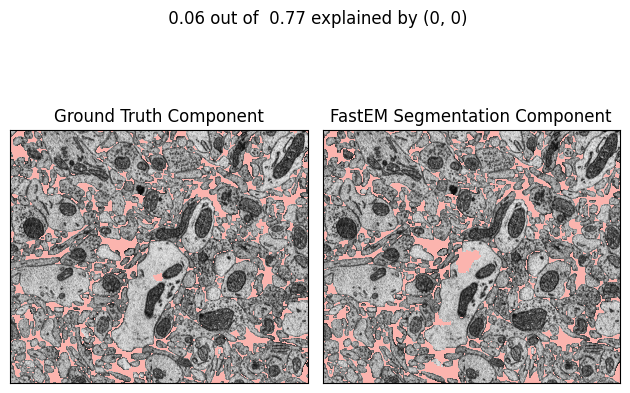

1351it [00:00, 274673.03it/s]         | 1/18 [00:04<01:17,  4.55s/it]


0.06817703005796023@(0, 318)


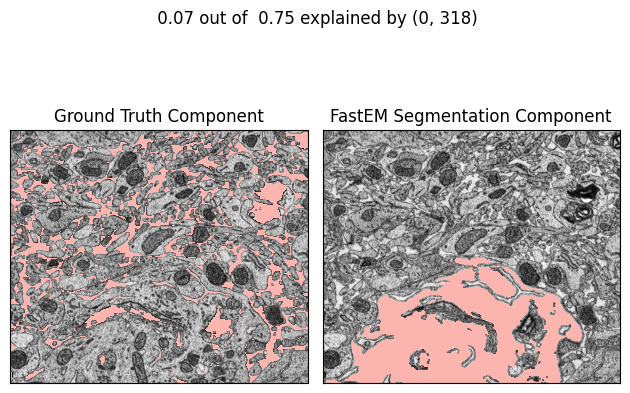

1410it [00:00, 280575.42it/s]         | 2/18 [00:09<01:14,  4.65s/it]


0.04848144824305277@(0, 0)


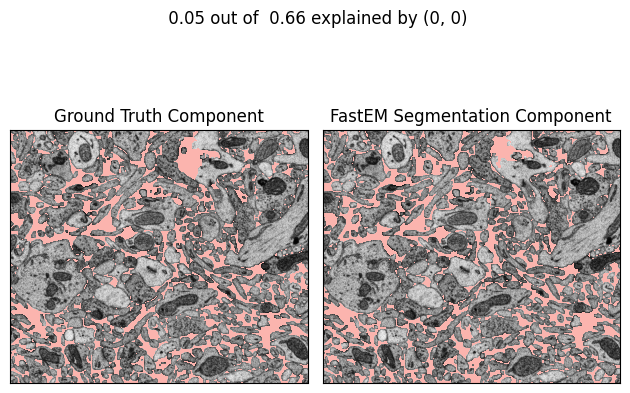

1178it [00:00, 276243.44it/s]▋        | 3/18 [00:13<01:09,  4.66s/it]


0.05694249859453584@(0, 0)


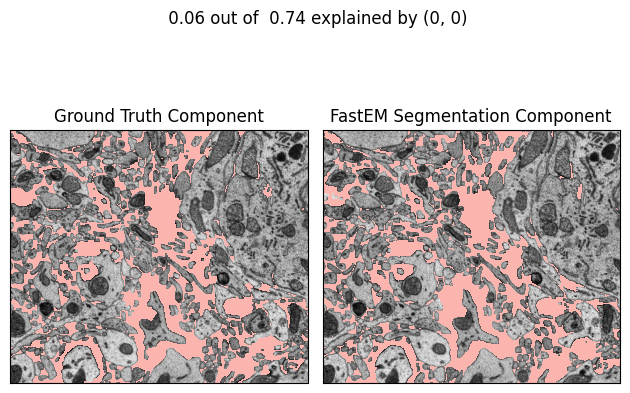

1047it [00:00, 275532.46it/s]█▏       | 4/18 [00:18<01:05,  4.65s/it]


0.0825537232966707@(0, 132)


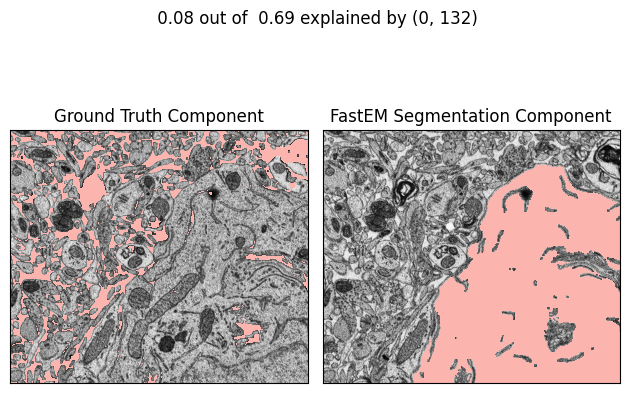

1540it [00:00, 275165.21it/s]█▊       | 5/18 [00:23<01:00,  4.66s/it]


0.06617678765913264@(0, 0)


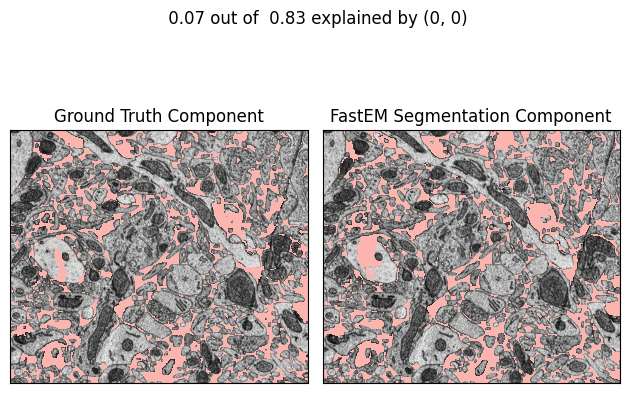

1516it [00:00, 262414.46it/s]██▎      | 6/18 [00:27<00:55,  4.62s/it]


0.055933873773651326@(0, 0)


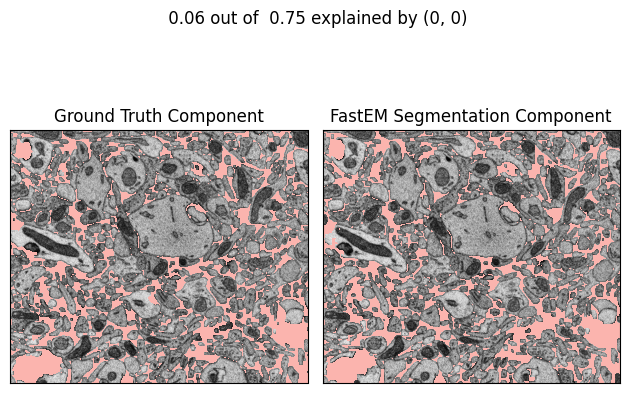

1408it [00:00, 275446.83it/s]██▉      | 7/18 [00:32<00:50,  4.62s/it]


0.050193940264923166@(0, 0)


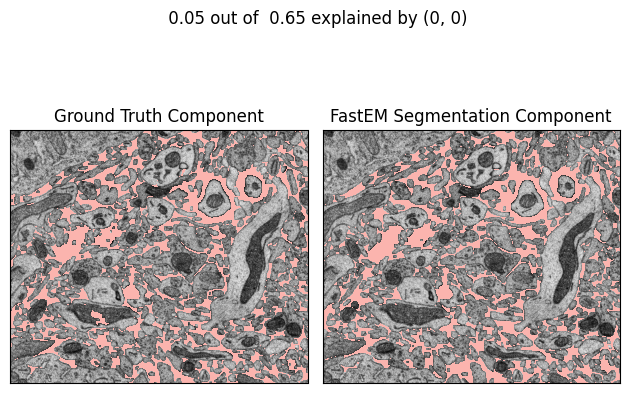

1500it [00:00, 270914.87it/s]███▍     | 8/18 [00:37<00:46,  4.64s/it]


0.07636427400434234@(0, 0)


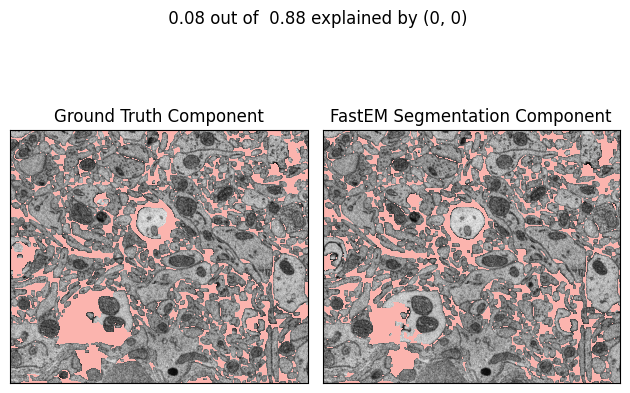

1438it [00:00, 273372.12it/s]████     | 9/18 [00:41<00:41,  4.65s/it]


0.06035172148195011@(0, 0)


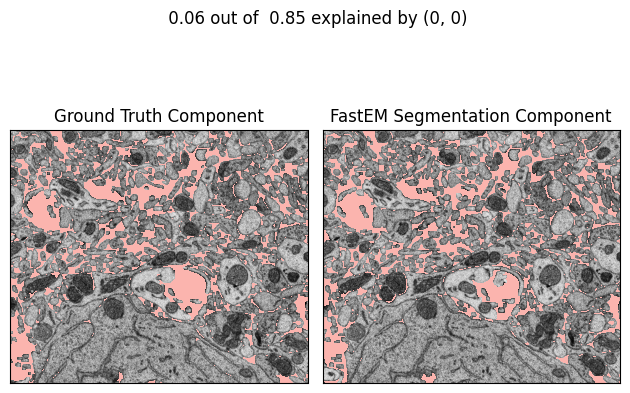

1492it [00:00, 270203.00it/s]████▌    | 10/18 [00:46<00:37,  4.66s/it]


0.05052201847824128@(0, 0)


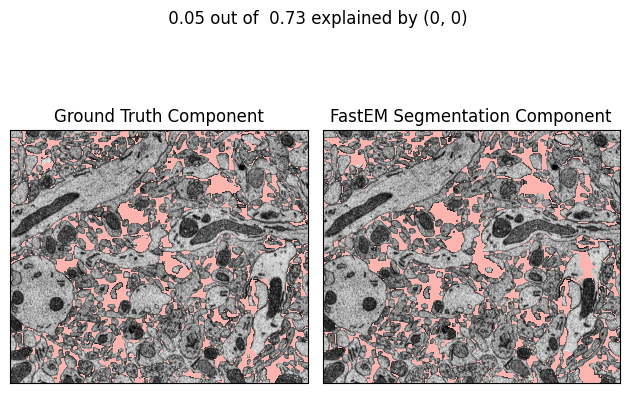

854it [00:00, 264135.06it/s]██████    | 11/18 [00:50<00:32,  4.62s/it]


0.17765953153789973@(0, 1)


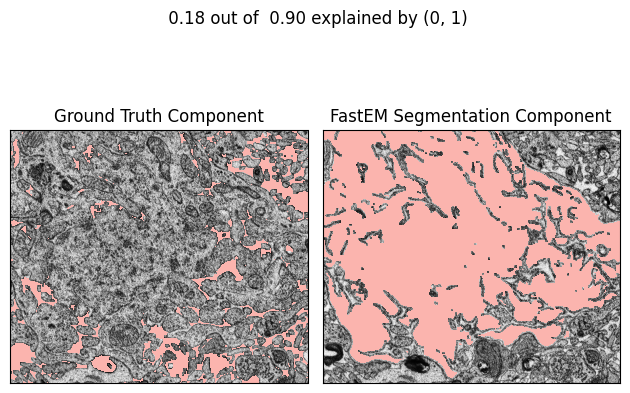

1303it [00:00, 278864.07it/s]█████▋   | 12/18 [00:55<00:27,  4.64s/it]


0.07323927841024579@(0, 0)


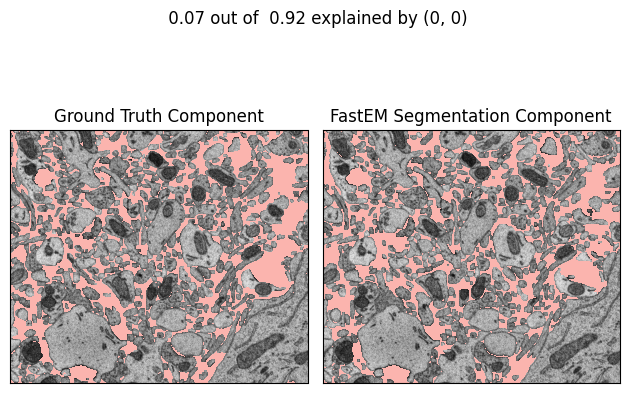

1329it [00:00, 283618.09it/s]██████▏  | 13/18 [01:00<00:23,  4.64s/it]


0.044820267844147166@(0, 0)


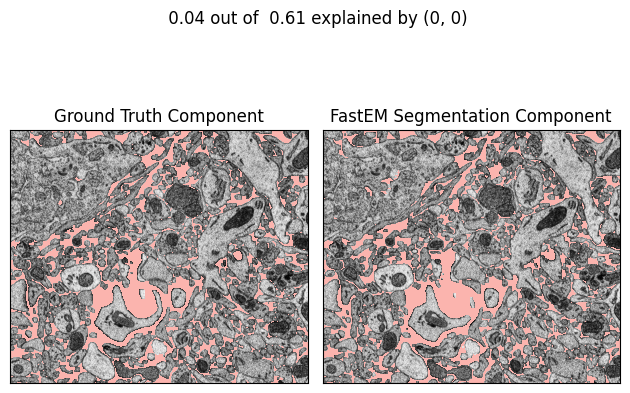

1454it [00:00, 273243.34it/s]██████▊  | 14/18 [01:04<00:18,  4.58s/it]


0.05915188369733946@(0, 0)


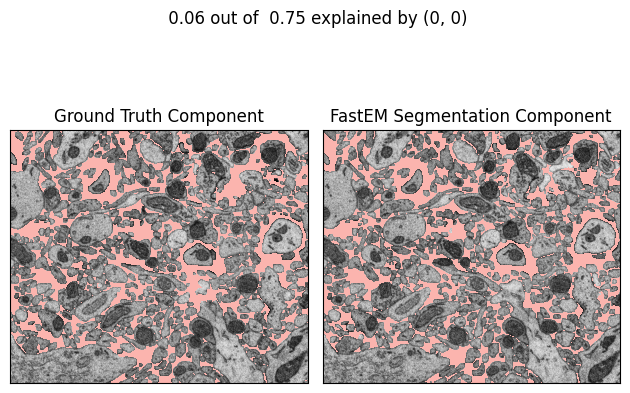

1451it [00:00, 269229.60it/s]███████▎ | 15/18 [01:09<00:13,  4.59s/it]


0.06876325384836353@(0, 0)


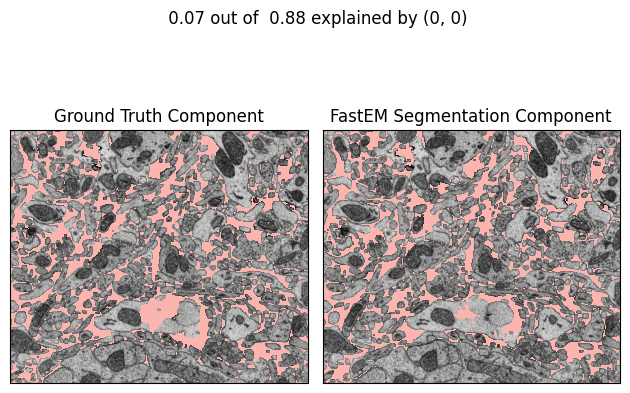

1266it [00:00, 277298.49it/s]███████▉ | 16/18 [01:13<00:09,  4.59s/it]


0.06247446759689601@(0, 0)


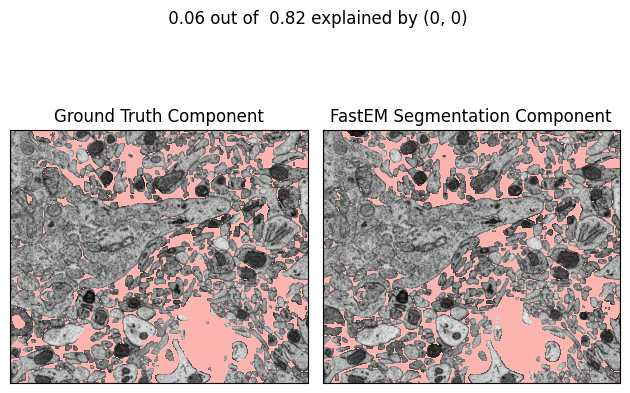

1490it [00:00, 245309.82it/s]████████▍| 17/18 [01:18<00:04,  4.60s/it]


0.06261575012255934@(0, 0)


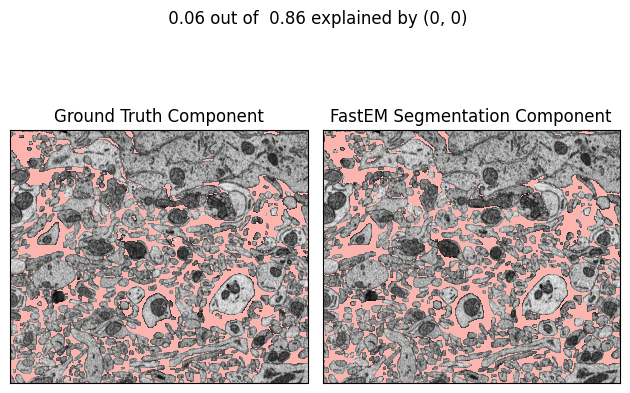

segmenting regions...: 100%|██████████| 18/18 [01:23<00:00,  4.62s/it]


In [60]:
data_precision = []
data_recall = []

data_vi = []
data_method = []

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]
        fastest_dwt = dwts[0]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        if gt_mask.shape[0] % 32 != 0:
            gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]
        gt_labels = measure.label(255 - gt_mask)

        fast_em = group[f"{fastest_dwt}/im"][()]

        fdt_lab = Iseg_us.get_labels(fast_em)
        voi_gt_us,_,_ = pyvoi.VI(gt_labels.flatten(), fdt_lab.flatten())
        voi_gt_us = voi_gt_us.item()
        R = vi(gt_labels, fdt_lab)

        argmax = np.argmax(R.flatten())
        coord = np.unravel_index(argmax, R.shape)
        c1, c2 = coord[0], coord[1]

        mask1 = np.ma.masked_array(gt_labels == c1, mask= (gt_labels != c1))
        mask2 = np.ma.masked_array(fdt_lab == c2, mask= (fdt_lab != c2))
        

        fig, axs = plt.subplots( ncols=2)
        axs[0].imshow(fast_em, cmap='gray')
        axs[0].imshow(mask1, cmap='Pastel1')
        axs[0].set_title("Ground Truth Component")
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        axs[1].imshow(fast_em, cmap='gray')
        axs[1].imshow(mask2, cmap='Pastel1')
        axs[1].set_title("FastEM Segmentation Component")
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        plt.suptitle(f"{R[coord[0], coord[1]]: .2f} out of {np.sum(R): .2f} explained by {coord}")
        fig.tight_layout()
        plt.show()



# MIT vs Core

In [ ]:
data_gt_vois = []
data_eff_dt = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for dwt in tqdm(valid_dwts, desc="varying effective dwell times..."):
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

            image_names = {}

            for dwt_save in dwts:
                im = group[f"{dwt_save}/im"][()]
                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt_save}.png"
                if not os.path.isfile(im_file_path):
                    io.imsave(im_file_path, im)

                image_names[dwt_save] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)

            # make smartem object us 
            params_us = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":0,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params_us)

            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_us.initialize(unet_version="offline")


            # make smartem object core
            params_core = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":0,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                "do_clahe": True,
            }
            get_rescan_map_core = get_rescan_maps.GetRescanMapMembraneErrors(params=params_core)

            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_core
            )
            my_smart_em_core.initialize(unet_version="online")

            # errnet
            params = {"fast_dwt": dwt*1e-9, "slow_dwt": dwt*1e-9, "plot": False}
            fast_em, _, _, *_ = my_smart_em_us.acquire(params=params)


            labels_us = Iseg_us.get_labels(fast_em)
            labels_core = Iseg_core.get_labels(fast_em)

            # Compute VI
            voi_gt_us,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            voi_gt_us = voi_gt_us.item()

            voi_gt_core,_,_ = pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            voi_gt_core = voi_gt_core.item()

            data_gt_vois.append(voi_gt_us)
            data_eff_dt.append(dwt)
            data_methods.append(f"SmartEM trained @ MIT: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_core)
            data_eff_dt.append(dwt)
            data_methods.append(f"SmartEM from Core: {fast_dwt}/{slow_dwt}ns")


data = {"Method": data_methods, "Variation of Information from GT": data_gt_vois, "Dwell Time (ns)": data_eff_dt}
df = pd.DataFrame(data=data)

In [ ]:
sns.stripplot(df, x="Dwell Time (ns)", y="Variation of Information from GT", hue="Method")

# Random rescan

In [ ]:
data_gt_vois = []
data_eff_dt = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for eff_dt in tqdm(valid_dwts[1:-3], desc="varying effective dwell times..."):
        rescan_ratio = (eff_dt - fast_dwt) / slow_dwt
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]
                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                if not os.path.isfile(im_file_path):
                    io.imsave(im_file_path, im)

                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)

            # make smartem object us 
            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_us.initialize(unet_version="offline")


            # make smartem object core
            params = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_core.initialize(unet_version="online")

            # errnet
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)

            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            _, _, rescan_map_core, *_ = my_smart_em_core.acquire(params=params)

            params = {"fast_dwt": eff_dt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            single_dt_em, _, _, *_ = my_smart_em_us.acquire(params=params)

            rescan_map_r = np.zeros(rescan_map.shape, dtype=bool)
            rand_coords = np.random.choice(np.arange(rescan_map_r.size), size = int(rescan_ratio*rescan_map_r.size), replace=False)
            rand_coords = np.unravel_index(rand_coords, rescan_map_r.shape)
            rescan_map_r[rand_coords[0], rand_coords[1]] = True


            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            merged_em_core = fast_em.copy()
            merged_em_core[rescan_map_core] = slow_em[rescan_map_core]
            merged_em_r = fast_em.copy()
            merged_em_r[rescan_map_r] = slow_em[rescan_map_r]
            print([(np.sum(rmap)/rmap.size, np.sum(mem == slow_em)/slow_em.size) for rmap, mem in zip([rescan_map, rescan_map_r, rescan_map_core], [merged_em, merged_em_r, merged_em_core])])
            
            labels_us = Iseg_us.get_labels(merged_em)
            labels_us_r = Iseg_us.get_labels(merged_em_r)
            labels_us_single = Iseg_us.get_labels(single_dt_em)
            labels_core = Iseg_core.get_labels(merged_em_core)


            # Compute VI
            voi_gt_us,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            voi_gt_us = voi_gt_us.item()

            voi_gt_core,_,_ = pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            voi_gt_core = voi_gt_core.item()

            voi_gt_us_r,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us_r.flatten())
            voi_gt_us_r = voi_gt_us_r.item()

            voi_gt_us_single,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us_single.flatten())
            voi_gt_us_single = voi_gt_us_single.item()

            data_gt_vois.append(voi_gt_us)
            data_eff_dt.append(eff_dt)
            data_methods.append(f"SmartEM trained @ MIT: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_core)
            data_eff_dt.append(eff_dt)
            data_methods.append(f"SmartEM from Core: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_us_r)
            data_eff_dt.append(eff_dt)
            data_methods.append(f"SmartEM random rescan: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_us_single)
            data_eff_dt.append(eff_dt)
            data_methods.append(f"Single Dwell Time")


data = {"Method": data_methods, "Variation of Information from GT": data_gt_vois, "Effective Dwell Time (ns)": data_eff_dt}
df = pd.DataFrame(data=data)

In [ ]:
sns.stripplot(data=df[df["Method"] != f"SmartEM from Core: {fast_dwt}/{slow_dwt}ns"], y="Variation of Information from GT", x="Effective Dwell Time (ns)", hue="Method")

# Understand Core code

segmenting regions...:   0%|          | 0/18 [00:00<?, ?it/s]

[0.765993595123291, -9.5367431640625e-07, 0.637941837310791]


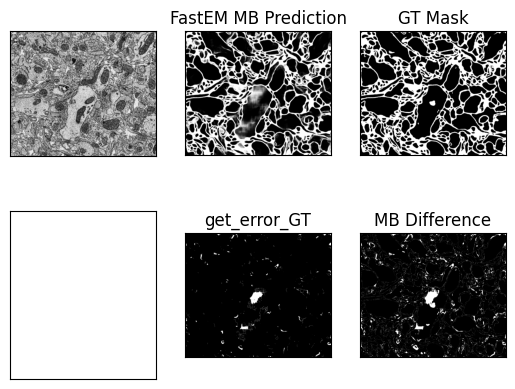

segmenting regions...:   6%|▌         | 1/18 [00:14<04:10, 14.75s/it]

[0.7478735446929932, 0.0, 0.6800811290740967]


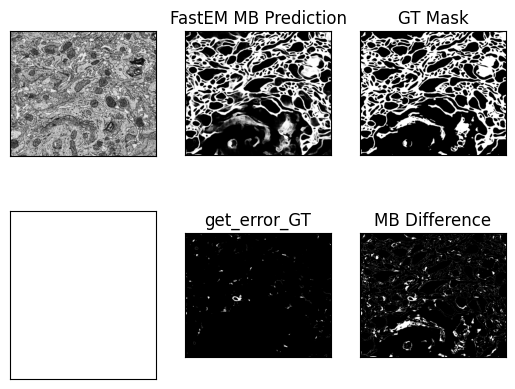

segmenting regions...:  11%|█         | 2/18 [00:28<03:46, 14.18s/it]

[0.6630525588989258, 0.0, 0.6034328937530518]


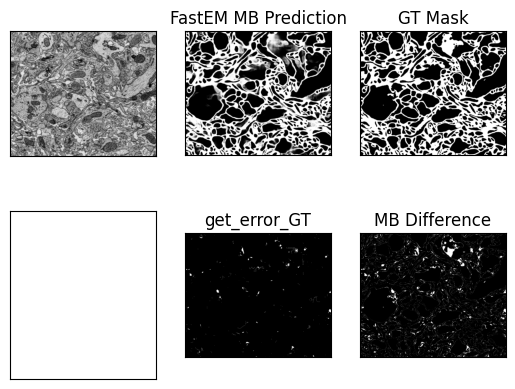

segmenting regions...:  17%|█▋        | 3/18 [00:43<03:41, 14.75s/it]

[0.7364523410797119, 4.76837158203125e-07, 0.6742556095123291]


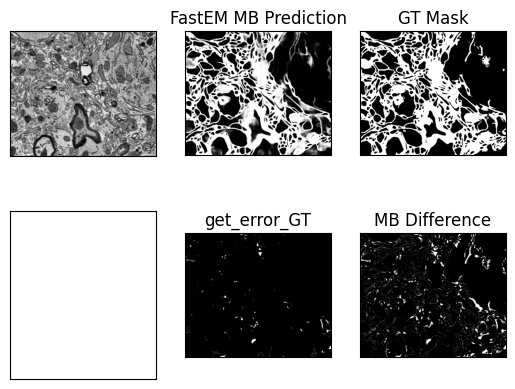

segmenting regions...:  22%|██▏       | 4/18 [00:58<03:23, 14.56s/it]

[0.6884739398956299, 9.5367431640625e-07, 0.647662878036499]


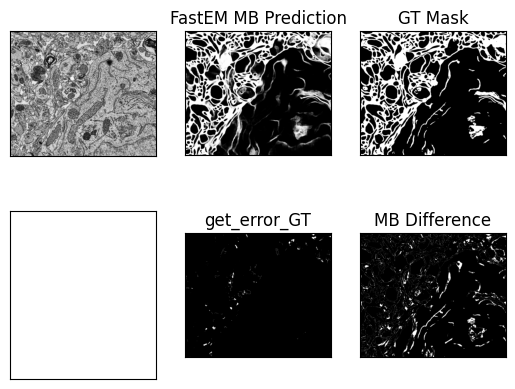

segmenting regions...:  28%|██▊       | 5/18 [01:09<02:53, 13.34s/it]

[0.8297028541564941, 9.5367431640625e-07, 0.6695315837860107]


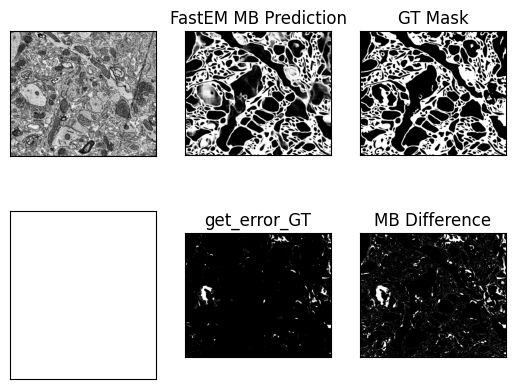

segmenting regions...:  33%|███▎      | 6/18 [01:24<02:45, 13.78s/it]

[0.7538201808929443, 1.430511474609375e-06, 0.6873500347137451]


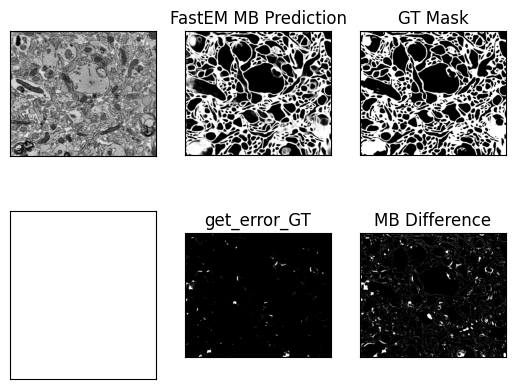

segmenting regions...:  39%|███▉      | 7/18 [01:38<02:32, 13.88s/it]

[0.6540977954864502, 0.0, 0.5534744262695312]


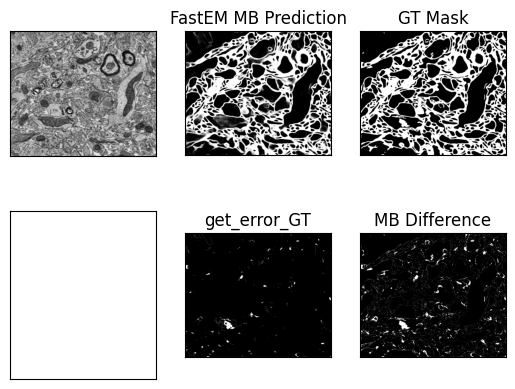

segmenting regions...:  44%|████▍     | 8/18 [01:51<02:18, 13.84s/it]

[0.8778343200683594, 4.76837158203125e-07, 0.6682419776916504]


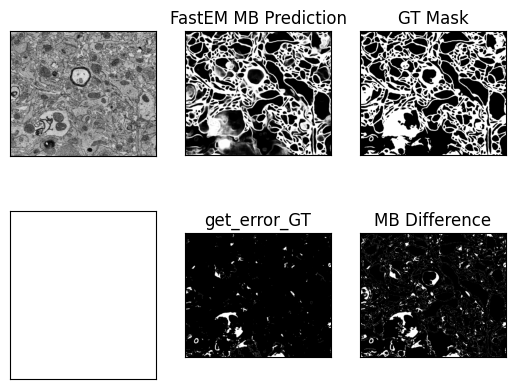

segmenting regions...:  50%|█████     | 9/18 [02:06<02:08, 14.24s/it]

[0.8516569137573242, -4.76837158203125e-07, 0.7815172672271729]


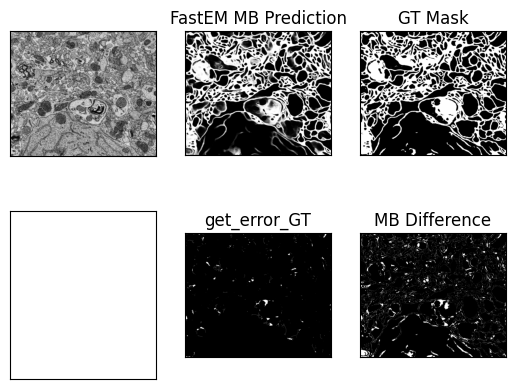

segmenting regions...:  56%|█████▌    | 10/18 [02:20<01:52, 14.08s/it]

[0.7281303405761719, 4.76837158203125e-07, 0.6852326393127441]


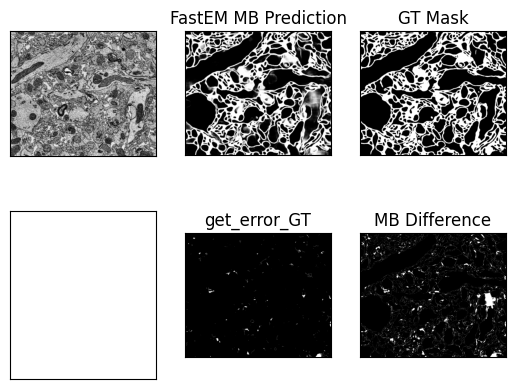

segmenting regions...:  61%|██████    | 11/18 [02:33<01:36, 13.82s/it]

[0.9029141664505005, 2.384185791015625e-07, 0.8465238809585571]


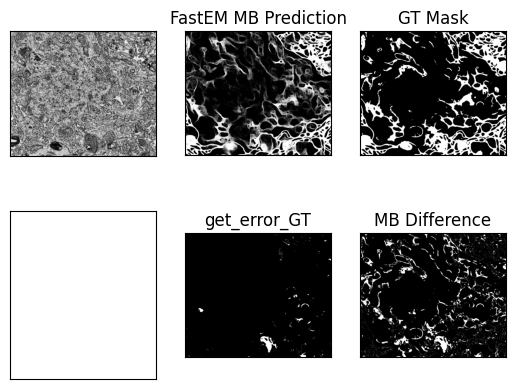

segmenting regions...:  67%|██████▋   | 12/18 [02:45<01:19, 13.22s/it]

[0.9246723651885986, -4.76837158203125e-07, 0.7947685718536377]


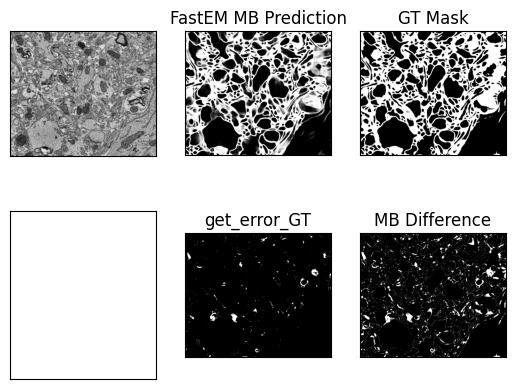

segmenting regions...:  72%|███████▏  | 13/18 [02:58<01:06, 13.21s/it]

[0.6082735061645508, 9.5367431640625e-07, 0.5671496391296387]


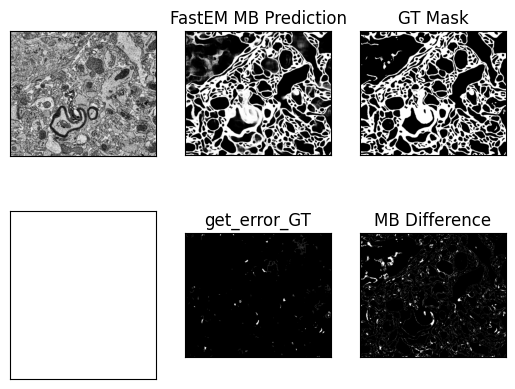

segmenting regions...:  78%|███████▊  | 14/18 [03:12<00:53, 13.28s/it]

[0.7529051303863525, 0.0, 0.6438367366790771]


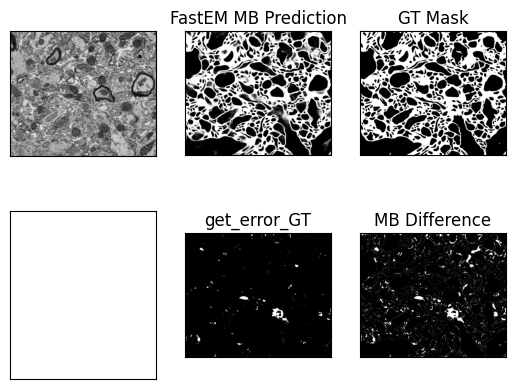

segmenting regions...:  83%|████████▎ | 15/18 [03:25<00:40, 13.34s/it]

[0.8838331699371338, -9.5367431640625e-07, 0.7701706886291504]


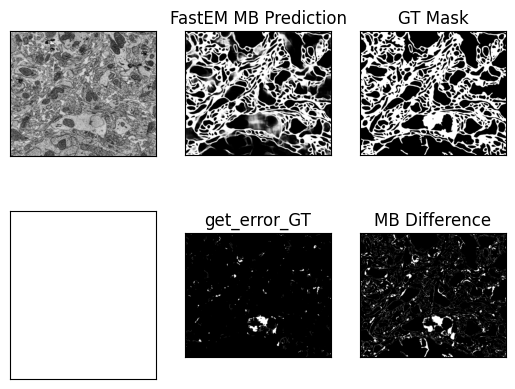

segmenting regions...:  89%|████████▉ | 16/18 [03:41<00:27, 13.92s/it]

[0.8194179534912109, 0.0, 0.7431139945983887]


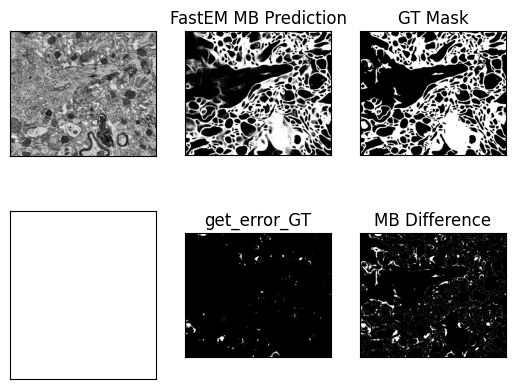

segmenting regions...:  94%|█████████▍| 17/18 [03:53<00:13, 13.53s/it]

[0.8563578128814697, 0.0, 0.7728803157806396]


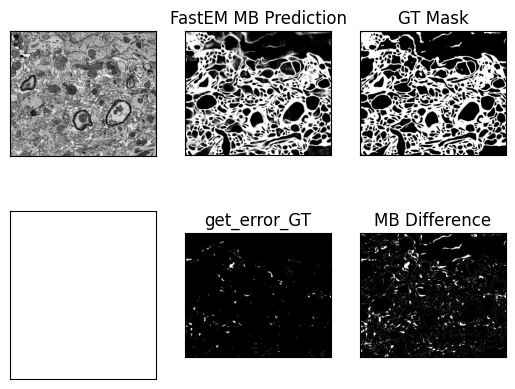

segmenting regions...: 100%|██████████| 18/18 [04:09<00:00, 13.84s/it]


In [11]:
data_precision = []
data_recall = []

data_vi = []
data_method = []

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]
        fastest_dwt = dwts[0]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        if gt_mask.shape[0] % 32 != 0:
            gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]
        gt_labels = measure.label(255 - gt_mask)


        image_names = {}

        fast_em = group[f"{fastest_dwt}/im"][()]

        fdt_mb, fdt_mb_probs = Iseg_us.get_membranes(fast_em, get_probs=True)
        fdt_mb_probs = (fdt_mb_probs * 255).astype(np.uint8)
        fdt_lab = Iseg_us.get_labels(fast_em)
        voi_gt_us,_,_ = pyvoi.VI(gt_labels.flatten(), fdt_lab.flatten())
        voi_gt_us = voi_gt_us.item()

        error_gt = get_error_GT(fdt_mb_probs, gt_mask)
        mb_diff = np.logical_xor(fdt_mb, gt_mask)

        fdt_mb_fix = fdt_mb.copy()
        fdt_mb_fix[mb_diff] = gt_mask[mb_diff]
        mb_fix = measure.label(255 - fdt_mb_fix)
        voi_fix_us,_,_ = pyvoi.VI(gt_labels.flatten(), mb_fix.flatten())
        voi_fix_us = voi_fix_us.item()

        fdt_mb_errfix = fdt_mb.copy()
        fdt_mb_errfix[error_gt] = gt_mask[error_gt]
        mb_errfix = measure.label(255 - fdt_mb_errfix)
        voi_errfix_us,_,_ = pyvoi.VI(gt_labels.flatten(), mb_errfix.flatten())
        voi_errfix_us = voi_errfix_us.item()

        print([voi_gt_us, voi_fix_us, voi_errfix_us])

        recall = np.sum(np.logical_and(mb_diff, error_gt))/np.sum(mb_diff)
        prec = np.sum(np.logical_and(mb_diff, error_gt))/np.sum(error_gt)

        data_precision.append(prec)
        data_recall.append(recall)

        data_vi.append(voi_gt_us)
        data_method.append("FastEM")
        data_vi.append(voi_fix_us)
        data_method.append("FastEM after fixing MB errors")
        data_vi.append(voi_errfix_us)
        data_method.append("FastEM after fixing get_error_GT locations")

        fig, axs = plt.subplots(ncols=3, nrows=2)
        axs[0,0].imshow(fast_em, cmap="gray")
        axs[0,1].imshow(fdt_mb_probs ,cmap='gray')
        axs[0,1].set_title("FastEM MB Prediction")
        axs[0,2].imshow(gt_mask ,cmap='gray')
        axs[0,2].set_title("GT Mask")
        axs[1,1].imshow(error_gt ,cmap='gray')
        axs[1,1].set_title("get_error_GT")
        axs[1,2].imshow(mb_diff ,cmap='gray')
        axs[1,2].set_title("MB Difference")
        for ax in axs.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()

data = {"Precision": data_precision, "Recall": data_recall}
df_mb = pd.DataFrame(data=data)

data = {"VI vs GT": data_vi, "Method": data_method}
df_vi = pd.DataFrame(data=data)



([0, 1, 2],
 [Text(0, 0, 'FastEM'),
  Text(1, 0, 'FastEM after fixing MB errors'),
  Text(2, 0, 'FastEM after fixing get_error_GT locations')])

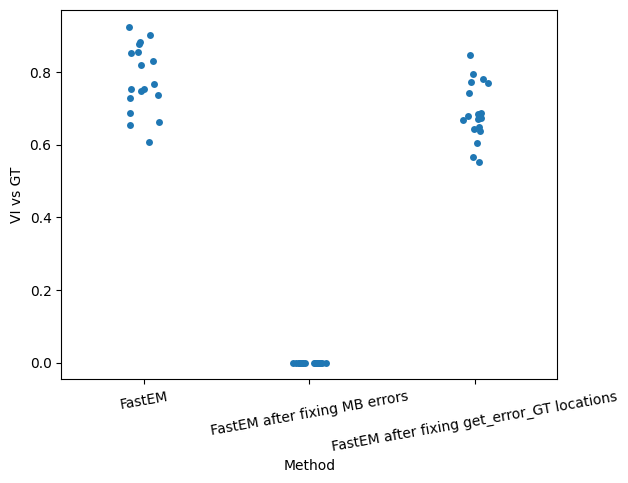

In [14]:
sns.stripplot(df_vi, x="Method", y="VI vs GT")
plt.xticks(rotation=10)


Text(0.5, 1.0, 'True MB Differences vs. get_error_GT')

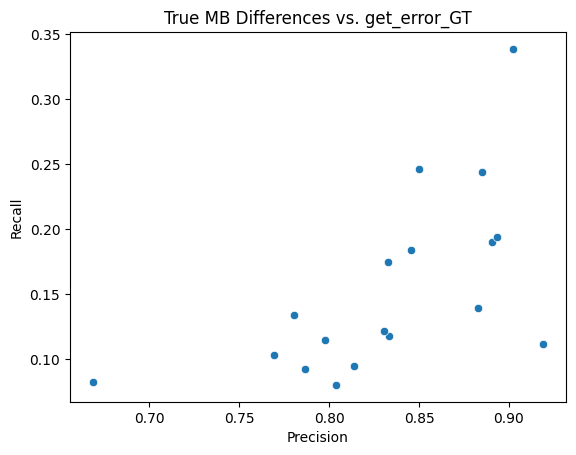

In [7]:
sns.scatterplot(df_mb, x="Precision", y="Recall")
plt.title("True MB Differences vs. get_error_GT")

In [ ]:
data_gt_vois = []
data_eff_dt = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - gt_mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]


        fast_em = group[f"50/im"][()]

        labels_us = Iseg_us.get_labels(fast_em)


        # Compute VI
        vi, vi_split, vi_merge, splitters, mergers = VI(gt_labels.flatten(), labels_us.flatten())

        print(len(np.unique(labels_us)))
        print(len(np.unique(gt_labels)))
        print(mergers.shape)
        print(splitters.shape)
        break
        #f, axs = plt.subplots(ncols=2)



# FOV Errors

## slow vs fast dt errors

In [ ]:
data_fixed_frac = []
data_fast_err = []
data_slow_err = []
data_new_frac = []

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        if gt_mask.shape[0] % 32 != 0:
            gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]

        gt_labels = measure.label(255 - gt_mask)


        image_names = {}

        for dwt in dwts:
            im = group[f"{dwt}/im"][()]
            im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
            if not os.path.isfile(im_file_path):
                io.imsave(im_file_path, im)

            image_names[dwt] = str(im_file_path)

        params = {"images_ns": image_names}
        my_microscope = microscope.FakeDataMicroscope(params=params)

        # make smartem object
        params = {
            "em2mb_net": em2mb_path_us,
            "error_net": errnet_path_us,
            "device": device,
            "pad": 0,
            "rescan_p_thres": None, # 0.1
            "rescan_ratio":0,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em_us = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )
        my_smart_em_us.initialize(unet_version="offline")

        # errnet
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)

        mbs_fast = Iseg_us.get_membranes(fast_em)
        mbs_slow = Iseg_us.get_membranes(slow_em)
        fixed_mistakes = np.logical_and(mbs_fast != gt_mask, mbs_slow == gt_mask)
        new_mistakes = np.logical_and(mbs_fast == gt_mask, mbs_slow != gt_mask)

        fixed_frac = np.sum(fixed_mistakes)/np.sum(mbs_fast != gt_mask)
        new_frac = np.sum(new_mistakes)/np.sum(mbs_slow != gt_mask)
        fast_err = np.sum(mbs_fast != gt_mask)/mbs_fast.size
        slow_err = np.sum(mbs_slow != gt_mask)/mbs_slow.size
        print(f"{fast_err} mistakes in fast EM with {fixed_frac} fixed in slow EM")

        data_fast_err.append(fast_err)
        data_slow_err.append(slow_err)
        data_fixed_frac.append(fixed_frac)
        data_new_frac.append(new_frac)


data = {"Fraction of MB Errors Fixed in SlowEM": data_fixed_frac, "MB Error rate slow EM": data_slow_err, "MB Error rate fast EM": data_fast_err, "Frac. of New MB Errors in SlowEM": data_new_frac}
df = pd.DataFrame(data=data)

In [ ]:
f, axs = plt.subplots(ncols=3)
axs[0].plot([0,0.1], [0,0.1])
sns.scatterplot(df, ax=axs[0], x="MB Error rate fast EM", y="MB Error rate slow EM")
sns.stripplot(df, ax=axs[1], y="Fraction of MB Errors Fixed in SlowEM")
sns.stripplot(df, ax=axs[2], y="Frac. of New MB Errors in SlowEM")
f.tight_layout()

## rescan fov

In [17]:
data_slow_r = []
data_err_frac = []
data_voi = []
data_voi_whole = []

err_region_r = 20
slow_rs = [0, 5, 10, 20, 40, 80, 160, 320]

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions...", disable=False):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        if gt_mask.shape[0] % 32 != 0:
            gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]

        gt_labels = measure.label(255 - gt_mask)

        image_names = {}

        for dwt in dwts:
            im = group[f"{dwt}/im"][()]
            im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
            if not os.path.isfile(im_file_path):
                io.imsave(im_file_path, im)

            image_names[dwt] = str(im_file_path)

        params = {"images_ns": image_names}
        my_microscope = microscope.FakeDataMicroscope(params=params)

        # make smartem object
        params = {
            "em2mb_net": em2mb_path_us,
            "error_net": errnet_path_us,
            "device": device,
            "pad": 0,
            "rescan_p_thres": None, # 0.1
            "rescan_ratio":0,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em_us = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )
        my_smart_em_us.initialize(unet_version="offline")

        # errnet
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)

        c = [s // 2 for s in fast_em.shape]

        mbs_fast = Iseg_us.get_membranes(fast_em)
        fast_mistakes = mbs_fast != gt_mask
        margin = slow_rs[-1]
        fast_mistakes[:margin,:] = 0
        fast_mistakes[-1*margin:,:] = 0
        fast_mistakes[:,-1*margin:] = 0
        fast_mistakes[:,:margin] = 0

        for i in range(10):
            next_fast_mistakes = ndi.binary_erosion(fast_mistakes)
            if np.sum(next_fast_mistakes) == 0:
                break
            else:
                fast_mistakes = next_fast_mistakes

        print(np.unique(measure.label(fast_mistakes)))

        err_coords = np.where(fast_mistakes)
        c = (err_coords[0][0], err_coords[1][0])

        for slow_r in tqdm(slow_rs, desc="varying slow em window size", leave=False):
            merged_em = fast_em.copy()

            if slow_r == 0:
                mbs_merged = Iseg_us.get_membranes(fast_em)
            else:
                merged_em[c[0]-slow_r:c[0]+slow_r, c[1]-slow_r:c[1]+slow_r] = slow_em[c[0]-slow_r:c[0]+slow_r, c[1]-slow_r:c[1]+slow_r]
                mbs_merged = Iseg_us.get_membranes(merged_em)
            
            smartem_seg = measure.label(255 - mbs_merged)

            merged_em_crop = merged_em[c[0]-err_region_r:c[0]+err_region_r, c[1]-err_region_r:c[1]+err_region_r]
            mbs_merged_crop = mbs_merged[c[0]-err_region_r:c[0]+err_region_r, c[1]-err_region_r:c[1]+err_region_r]
            smartem_seg_crop = smartem_seg[c[0]-err_region_r:c[0]+err_region_r, c[1]-err_region_r:c[1]+err_region_r]
            gt_mask_crop = gt_mask[c[0]-err_region_r:c[0]+err_region_r, c[1]-err_region_r:c[1]+err_region_r]
            gt_labels_crop = gt_labels[c[0]-err_region_r:c[0]+err_region_r, c[1]-err_region_r:c[1]+err_region_r]


            err_frac = np.sum(mbs_merged_crop != gt_mask_crop)/gt_mask_crop.size
            voi,_,_ = pyvoi.VI(gt_labels_crop.flatten(), smartem_seg_crop.flatten())
            voi = voi.item()
            voi_whole,_,_ = pyvoi.VI(gt_labels.flatten(), smartem_seg.flatten())
            voi_whole = voi_whole.item()
            
            data_slow_r.append(slow_r)
            data_err_frac.append(err_frac)
            data_voi.append(voi)
            data_voi_whole.append(voi_whole)



data = {f"Error Fraction in window around error r={err_region_r}": data_err_frac, "Size of SlowEM window": data_slow_r, f"VoI in window around error r={err_region_r}": data_voi, "VoI": data_voi_whole}
df = pd.DataFrame(data=data)

segmenting regions...:   0%|          | 0/18 [00:00<?, ?it/s]

[0 1 2 3]


segmenting regions...:   6%|▌         | 1/18 [00:06<01:47,  6.31s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


segmenting regions...:  11%|█         | 2/18 [00:12<01:39,  6.21s/it]

[0 1 2 3 4 5 6]


segmenting regions...:  17%|█▋        | 3/18 [00:18<01:32,  6.15s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


segmenting regions...:  22%|██▏       | 4/18 [00:24<01:26,  6.17s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


segmenting regions...:  28%|██▊       | 5/18 [00:30<01:20,  6.17s/it]

[0 1 2 3 4 5 6 7 8 9]


segmenting regions...:  33%|███▎      | 6/18 [00:36<01:13,  6.13s/it]

[0 1 2 3 4 5 6 7 8 9]


segmenting regions...:  39%|███▉      | 7/18 [00:43<01:07,  6.15s/it]

[0 1 2 3 4 5 6 7 8]


segmenting regions...:  44%|████▍     | 8/18 [00:49<01:01,  6.16s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11]


segmenting regions...:  50%|█████     | 9/18 [00:55<00:55,  6.16s/it]

[0 1 2 3 4 5 6]


segmenting regions...:  56%|█████▌    | 10/18 [01:01<00:49,  6.16s/it]

[0 1 2 3 4]


segmenting regions...:  61%|██████    | 11/18 [01:07<00:43,  6.16s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


segmenting regions...:  67%|██████▋   | 12/18 [01:13<00:36,  6.14s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


segmenting regions...:  72%|███████▏  | 13/18 [01:19<00:30,  6.11s/it]

[0 1 2 3]


segmenting regions...:  78%|███████▊  | 14/18 [01:25<00:24,  6.10s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11]


segmenting regions...:  83%|████████▎ | 15/18 [01:32<00:18,  6.09s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


segmenting regions...:  89%|████████▉ | 16/18 [01:38<00:12,  6.12s/it]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


segmenting regions...:  94%|█████████▍| 17/18 [01:44<00:06,  6.13s/it]

[0 1 2 3 4 5 6 7 8]


segmenting regions...: 100%|██████████| 18/18 [01:50<00:00,  6.14s/it]


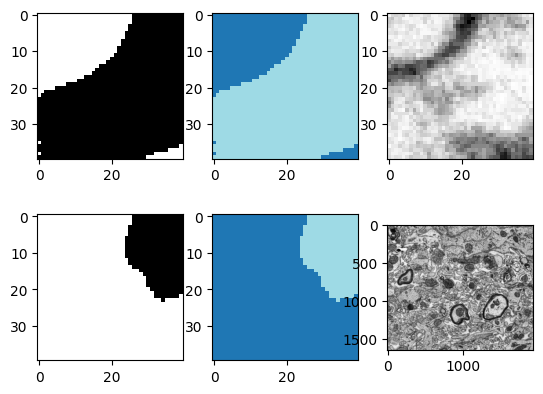

In [18]:
f, axs = plt.subplots(nrows = 2, ncols = 3)

axs[0, 0].imshow(mbs_merged_crop, cmap='gray')
axs[1, 0].imshow(gt_mask_crop, cmap='gray')

axs[0, 1].imshow(smartem_seg_crop % 20, cmap='tab20')
axs[1, 1].imshow(gt_labels_crop % 20, cmap='tab20')

axs[0, 2].imshow(merged_em_crop, cmap='gray')
axs[1, 2].imshow(merged_em, cmap='gray')

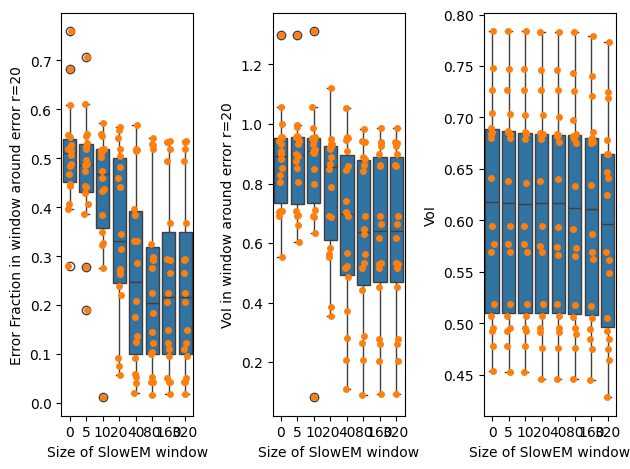

In [19]:
f, axs = plt.subplots(ncols = 3)

sns.boxplot(df, ax=axs[0], x="Size of SlowEM window", y=f"Error Fraction in window around error r={err_region_r}")
sns.stripplot(df, ax=axs[0], x="Size of SlowEM window", y=f"Error Fraction in window around error r={err_region_r}")

sns.boxplot(df, ax=axs[1], x="Size of SlowEM window", y=f"VoI in window around error r={err_region_r}")
sns.stripplot(df, ax=axs[1], x="Size of SlowEM window", y=f"VoI in window around error r={err_region_r}")

sns.boxplot(df, ax=axs[2], x="Size of SlowEM window", y=f"VoI")
sns.stripplot(df, ax=axs[2], x="Size of SlowEM window", y=f"VoI")

f.tight_layout()

## 80 rad experiment

In [ ]:
def rescan_oracle(pred_mask, gt_mask, window_r = 80, rescan_ratio = 0.05, margin=100):
    mistakes = pred_mask != gt_mask

    # black out margin
    mistakes[:margin,:] = 0
    mistakes[-1*margin:,:] = 0
    mistakes[:,-1*margin:] = 0
    mistakes[:,:margin] = 0


    # find large error regions
    for _ in range(10):
        next_mistakes = ndi.binary_erosion(mistakes)
        if np.sum(next_mistakes) == 0:
            break
        else:
            mistakes = next_mistakes


    rescan_mask = np.zeros_like(pred_mask)

    mistake_labels = measure.label(mistakes)
    mistake_regs = measure.regionprops(mistake_labels)

    for reg in mistake_regs:
        c = reg.centroid
        c = [int(e) for e in c]

        rescan_mask_next = rescan_mask.copy()
        rescan_mask_next[c[0]-window_r:c[0]+window_r, c[1]-window_r:c[1]+window_r] = 1

        if np.sum(rescan_mask_next)/rescan_mask_next.size > rescan_ratio:
            break
        else:
            rescan_mask = rescan_mask_next

    extra_pixels = int(int(rescan_ratio*rescan_mask.size) - np.sum(rescan_mask))
    if extra_pixels > 0:
        no_rescan = np.where(rescan_mask == 0)
        for c in zip(no_rescan[0][:extra_pixels], no_rescan[1][:extra_pixels]):
            rescan_mask[c[0], c[1]] = 1

    assert np.sum(rescan_mask)/rescan_mask.size <= rescan_ratio

    return rescan_mask
    

In [ ]:
data_err_frac = []
data_voi_whole = []
data_method = []

err_region_r = 20
slow_r = 80

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions...", disable=False):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        if gt_mask.shape[0] % 32 != 0:
            gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]

        gt_labels = measure.label(255 - gt_mask)

        image_names = {}

        for dwt in dwts:
            im = group[f"{dwt}/im"][()]
            im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
            if not os.path.isfile(im_file_path):
                io.imsave(im_file_path, im)

            image_names[dwt] = str(im_file_path)

        params = {"images_ns": image_names}
        my_microscope = microscope.FakeDataMicroscope(params=params)

        # make smartem object
        params = {
            "em2mb_net": em2mb_path_us,
            "error_net": errnet_path_us,
            "device": device,
            "pad": 0,
            "rescan_p_thres": None, # 0.1
            "rescan_ratio":0,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em_us = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )
        my_smart_em_us.initialize(unet_version="offline")

        # errnet
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)

        mbs_fast = Iseg_us.get_membranes(fast_em)
        fast_seg = measure.label(255 - mbs_fast)
        rescan_mask = rescan_oracle(mbs_fast, gt_mask)
        print(np.sum(rescan_mask)/rescan_mask.size)
        rescan_mask = np.pad(rescan_mask, ((4,4), (0,0)))

        merged_em = fast_em.copy()
        merged_em[rescan_mask > 0] = slow_em[rescan_mask > 0]

        mbs_merged = Iseg_us.get_membranes(merged_em)
        smartem_seg = measure.label(255 - mbs_merged)

        err_frac = np.sum(mbs_merged != gt_mask)/gt_mask.size
        voi_whole,_,_ = pyvoi.VI(gt_labels.flatten(), smartem_seg.flatten())
        voi_whole = voi_whole.item()
        
        data_err_frac.append(err_frac)
        data_voi_whole.append(voi_whole)
        data_method.append("SmartEM")

        err_frac = np.sum(mbs_fast != gt_mask)/gt_mask.size
        voi_whole,_,_ = pyvoi.VI(gt_labels.flatten(), fast_seg.flatten())
        voi_whole = voi_whole.item()

        data_err_frac.append(err_frac)
        data_voi_whole.append(voi_whole)
        data_method.append("Single DT")

data = {f"Error Fraction with rescan windows r={slow_r}": data_err_frac,  "VoI": data_voi_whole, "Method": data_method}
df = pd.DataFrame(data=data)

f, axs = plt.subplots(ncols = 2)

sns.boxplot(df, ax=axs[0], x="Method", y=f"Error Fraction with rescan windows r={slow_r}")
sns.stripplot(df, ax=axs[0], x="Method", y=f"Error Fraction with rescan windows r={slow_r}")

sns.boxplot(df, ax=axs[1], x="Method", y=f"VoI")
sns.stripplot(df, ax=axs[1], x="Method", y=f"VoI")

f.tight_layout()

## Eff DT

In [ ]:
data_err_frac = []
data_voi = []
data_method = []
data_eff_dt = []

err_region_r = 20
slow_r = 80

fast_dwt = 50
slow_dwt = 800


with h5py.File(hdf5_path, 'r') as f:
    for eff_dt in tqdm(valid_dwts[1:-3], desc="varying effective dwell times..."): #-3
        rescan_ratio = (eff_dt - fast_dwt) / slow_dwt
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=False):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            if gt_mask.shape[0] % 32 != 0:
                gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]

            gt_labels = measure.label(255 - gt_mask)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]
                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                if not os.path.isfile(im_file_path):
                    io.imsave(im_file_path, im)

                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)

            # make smartem object
            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":0,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_us.initialize(unet_version="offline")

            # errnet
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, _, *_ = my_smart_em_us.acquire(params=params)

            mbs_fast = Iseg_us.get_membranes(fast_em)

            rescan_mask = rescan_oracle(mbs_fast, gt_mask, rescan_ratio=rescan_ratio)
            rescan_mask = np.pad(rescan_mask, ((4,4), (0,0)))


            merged_em = fast_em.copy()
            assert (merged_em == fast_em).all()
            merged_em[rescan_mask > 0] = slow_em[rescan_mask > 0]
            assert np.sum(merged_em != fast_em) <= np.sum(rescan_mask)
            assert (merged_em[rescan_mask > 0] == slow_em[rescan_mask > 0]).all()

            mbs_merged = Iseg_us.get_membranes(merged_em)
            smartem_seg = measure.label(255 - mbs_merged)

            err_frac = np.sum(mbs_merged != gt_mask)/gt_mask.size
            voi,_,_ = pyvoi.VI(gt_labels.flatten(), smartem_seg.flatten())
            voi = voi.item()
            
            data_err_frac.append(err_frac)
            data_voi.append(voi)
            data_method.append("SmartEM w/Oracle ERRNET")
            data_eff_dt.append(eff_dt)


            # single dt
            params = {"fast_dwt": eff_dt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            single_dt_em, _, _, *_ = my_smart_em_us.acquire(params=params)


            mbs_single = Iseg_us.get_membranes(single_dt_em)
            single_seg = measure.label(255 - mbs_single)

            err_frac = np.sum(mbs_single != gt_mask)/gt_mask.size
            voi,_,_ = pyvoi.VI(gt_labels.flatten(), single_seg.flatten())
            voi = voi.item()

            data_err_frac.append(err_frac)
            data_voi.append(voi)
            data_method.append("Single DT")
            data_eff_dt.append(eff_dt)



data = {f"MB Error Fraction": data_err_frac,  "VoI": data_voi, "Method": data_method, "Effective Dwell Time (ns)": data_eff_dt}
df = pd.DataFrame(data=data)


f, axs = plt.subplots(ncols = 2)
sns.stripplot(df, ax=axs[0],  x="Effective Dwell Time (ns)", y="MB Error Fraction", hue="Method")
sns.stripplot(df, ax=axs[1],  x="Effective Dwell Time (ns)", y="VoI", hue="Method")
f.tight_layout()

# Rescan oracle

In [ ]:
data_hdt_vois = []
data_re_ratio = []
data_methods = []
data_rescan = []
data_rescan_size = []

core = False
us = True
mb_replace = True
rescan_maps_error_GT = {}
rescan_maps_xor = {}
fdt_mb_probs = {}
sdt_mb_probs = {}

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions...", disable=False):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - gt_mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # get hdt labels
        slowest_em = group[f"{slowest_dwt}/im"][()]

        if us:
            hdt_membrane_mask_us, hdt_mb_probs_us = Iseg_us.get_membranes(slowest_em, get_probs=True)
            hdt_mb_probs_us = (hdt_mb_probs_us*255).astype(np.uint8)
            hdt_labels_us = Iseg_us.get_labels(slowest_em)
        if core:
            hdt_membrane_mask_core, hdt_mb_probs_core = Iseg_core.get_membranes(slowest_em, get_probs=True)
            hdt_mb_probs_core = (hdt_mb_probs_core*255).astype(np.uint8)
            hdt_labels_core = Iseg_core.get_labels(slowest_em)

        # acquire
        fast_em = group[f"{fast_dwt}/im"][()]
        slow_em = group[f"{slow_dwt}/im"][()]

        if us:
            # Rescan
            fdt_labels_us = Iseg_us.get_labels(fast_em)
            mb_mask, mb_probs = Iseg_us.get_membranes(fast_em, get_probs=True)
            mb_probs = (mb_probs*255).astype(np.uint8)

            fdt_mb_probs[reg] = mb_probs
            
            rescan_map, _, _ = get_error_GT(mb_probs, hdt_mb_probs_us)
            
            rescan_maps_error_GT[reg] = rescan_map

            # counter = 0
            # counter2 = 0
            # for i in range(10):
            #     rescan_map_temp = ndi.binary_dilation(rescan_map)
            #     if np.sum(rescan_map_temp)/rescan_map_temp.size < 0.05:
            #         counter += 1
            #         rescan_map = rescan_map_temp
            #     else:
            #         q = rescan_map.shape[0] // 10
            #         for x1 in range(0,rescan_map.shape[0],q):
            #             rescan_map_temp = rescan_map.copy()
            #             rescan_map_temp_part = ndi.binary_dilation(rescan_map[x1:x1+q,:])
            #             rescan_map_temp[x1:x1+q,:] = rescan_map_temp_part
            #             if np.sum(rescan_map_temp)/rescan_map_temp.size < 0.05:
            #                 counter2 += 1
            #                 rescan_map = rescan_map_temp
            #             else:
            #                 break
            # print(f"{counter}x primary dilation {counter2}x secondary dilation")
                    
            rescan_map = np.logical_xor(mb_mask, hdt_membrane_mask_us)
            rescan_maps_xor[reg] = rescan_map
            data_rescan_size.append(np.sum(rescan_map))
            #rescan_map = np.pad(rescan_map, ((4,4),(0,0)))

            if mb_replace:
                mb_mask[rescan_map] = hdt_membrane_mask_us[rescan_map]
                labels_us = segmentation.watershed(mb_mask)
                #labels_us = measure.label(255-mb_mask)
            else:
                merged_em = fast_em.copy()
                merged_em[rescan_map] = slowest_em[rescan_map]
                print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
                labels_us = Iseg_us.get_labels(merged_em)



        if core:
            fdt_labels_core = Iseg_core.get_labels(fast_em)
            mb_mask, mb_probs = Iseg_core.get_membranes(fast_em, get_probs=True)
            mb_probs = (mb_probs*255).astype(np.uint8)
            rescan_map,_,_ = get_error_GT(mb_probs, hdt_mb_probs_core)

            counter = 0
            counter2 = 0
            for i in range(10):
                rescan_map_temp = ndi.binary_dilation(rescan_map)
                if np.sum(rescan_map_temp)/rescan_map_temp.size < 0.05:
                    counter += 1
                    rescan_map = rescan_map_temp
                else:
                    q = rescan_map.shape[0] // 10
                    for x1 in range(0,rescan_map.shape[0],q):
                        rescan_map_temp = rescan_map.copy()
                        rescan_map_temp_part = ndi.binary_dilation(rescan_map[x1:x1+q,:])
                        rescan_map_temp[x1:x1+q,:] = rescan_map_temp_part
                        if np.sum(rescan_map_temp)/rescan_map_temp.size < 0.05:
                            counter2 += 1
                            rescan_map = rescan_map_temp
                        else:
                            break
            print(f"{counter}x primary dilation {counter2}x secondary dilation")
               

            #rescan_map = np.logical_xor(mb_mask, hdt_membrane_mask_core)
            #rescan_map = np.pad(rescan_map, ((4,4),(0,0)))
            
            print(f"{np.sum(rescan_map)/rescan_map.size}")


            if mb_replace:
                mb_mask[rescan_map] = hdt_membrane_mask_core[rescan_map]
                labels_core = segmentation.watershed(mb_mask)
                #labels_core = measure.label(255-mb_mask)
            else:
                merged_em = fast_em.copy()
                merged_em[rescan_map] = slowest_em[rescan_map]
                labels_core = Iseg_core.get_labels(merged_em)

    
        if us:
            # Compute VI
            voi_gt_us,_,_ = -1, 0, 0 #pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            voi_hdt_us,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            voi_hdt_us = voi_hdt_us.item()
        if core:
            voi_gt_core,_,_ = -1, 0, 0 # pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            voi_hdt_core,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi_hdt_core = voi_hdt_core.item()

        if us:
            voi,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            voi = voi.item()
            data_hdt_vois.append(voi)
            data_methods.append(f"Trained @ MIT: {fast_dwt}/{slow_dwt}ns")
            data_rescan.append("Fixing membrane mask")

            voi,_,_ = pyvoi.VI(hdt_labels_us.flatten(), fdt_labels_us.flatten())
            voi = voi.item()
            data_hdt_vois.append(voi)
            data_methods.append(f"Trained @ MIT: {fast_dwt}/{slow_dwt}ns")
            data_rescan.append("No fixing")

        if core:
            voi,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi = voi.item()
            data_hdt_vois.append(voi)
            data_methods.append(f"Trained by Core: {fast_dwt}/{slow_dwt}ns")
            data_rescan.append("Replacement")

            voi,_,_ = pyvoi.VI(hdt_labels_core.flatten(), fdt_labels_core.flatten())
            voi = voi.item()
            data_hdt_vois.append(voi)
            data_methods.append(f"Trained by Core: {fast_dwt}/{slow_dwt}ns")
            data_rescan.append("No replacement")

data = {"Method": data_methods, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois, "Rescan Status": data_rescan}
df = pd.DataFrame(data=data)

In [ ]:
from scipy.stats import entropy

def calculate_image_entropy(image):
    """
    Calculate the entropy of an image based on the histogram of pixel values.

    Args:
    image (np.array): A grayscale image with pixel values.

    Returns:
    float: The entropy of the image.
    """
    # Flatten the image to 1D array
    pixel_values = image.flatten()
    # Compute histogram of pixel values
    histogram, _ = np.histogram(pixel_values, bins=256, range=[0, 256], density=True)
    # Remove zeros to avoid issues with log calculations in entropy
    histogram_nonzero = histogram[histogram > 0]
    # Calculate entropy using the histogram values
    return entropy(histogram_nonzero)



In [ ]:
# plot the fdt_mb_probs, rescan_maps_error_GT, rescan_maps_xor in subplots for a particular ID
id = '008_1_2'
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(fdt_mb_probs[id], cmap = 'gray')
axes[0].set_title("MB probs")
axes[0].axis('off')
error_GT = ndi.binary_dilation(rescan_maps_error_GT[id], iterations=4)
percentage_pixels_error_GT = np.sum(error_GT)/error_GT.size
entropy_error_GT = calculate_image_entropy(error_GT)
axes[1].imshow(error_GT, cmap = 'gray')
axes[1].set_title(f"Error GT rescan map {percentage_pixels_error_GT*100:.2f} %\n Entropy {entropy_error_GT:.2f}")
axes[1].axis('off')
axes[2].imshow(rescan_maps_xor[id], cmap = 'gray')
percentage_pixels_xor = np.sum(rescan_maps_xor[id])/rescan_maps_xor[id].size
entropy_xor = calculate_image_entropy(rescan_maps_xor[id])
axes[2].set_title(f"XOR rescan map {percentage_pixels_xor*100:.2f} %\n Entropy {entropy_xor:.2f}")
axes[2].axis('off')


plt.show()

In [ ]:

print(f"Entropy of error GT: {entropy_error_GT}")
print(f"Entropy of XOR: {entropy_xor}")


In [ ]:
data = h5py.File(hdf5_path, 'r')

In [ ]:
fdt_mb_probs.keys()


In [ ]:
from scipy import ndimage as ndi
id = '008_1_2'

mb_probs = fdt_mb_probs[id]

xor = rescan_maps_xor[id]
error_GT = rescan_maps_error_GT[id]
xor_masked = np.ma.masked_where(xor == 0, xor)

error_GT_dilation = ndi.binary_dilation(error_GT, iterations=8)
error_GT_dilation_masked = np.ma.masked_where(error_GT_dilation == 0, error_GT_dilation)


# plt.imshow(xor, cmap = 'autumn')

plt.imshow(xor, cmap='gray', alpha = 1.0)
# plt.imshow(error_GT_dilation_masked, cmap='Wistia', alpha=0.25)

# plt.imshow(mb_probs, cmap='gray', alpha=0.25)
# plt.imshow()
# plt.imshow(rescan_maps_xor['003_1_2'], cmap = 'gray')
# plt.imshow(rescan_maps_error_GT['003_1_2'], cmap = 'Wistia')

In [ ]:
print(np.sum(xor_dilated)/xor_dilated.size)

In [ ]:
plt.imshow(rescan_maps_error_GT['003_1_2'], cmap = 'gray')

In [ ]:
plot = sns.stripplot(data=df, y="Variation of Information from Slow Dwell Time Segmentation", x="Rescan Status")
plot.set(title=f'Fixing Membrane Mask @ Discrepancies ({np.mean(data_rescan_size)/rescan_map.size*100: .1f}% of pixels on average) \n Watershed segmentation')
sns.move_legend(plot, "upper right")
plt.tight_layout()

## Vary rescan ratio

In [ ]:
data_hdt_vois = []
data_gt_vois = []
data_re_ratio = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratios..."):
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
            #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

            # get hdt labels
            slowest_em = group[f"{slowest_dwt}/im"][()]
            hdt_labels_us = Iseg_us.get_labels(slowest_em)
            hdt_labels_core = Iseg_core.get_labels(slowest_em)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]
                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                if not os.path.isfile(im_file_path):
                    io.imsave(im_file_path, im)

                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)

            # make smartem object
            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_us.initialize(unet_version="offline")

            params = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_core.initialize(unet_version="online")

            # # acquire
            # fast_em = group[f"{fast_dwt}/im"][()]
            # slow_em = group[f"{slow_dwt}/im"][()]
            # # uncertainty
            # _, mb_probs = Iseg_us.get_membranes(fast_em, get_probs=True)
            # mb_certainty = np.abs(0.5 - mb_probs)
            # argmin = np.unravel_index(np.argmin(mb_certainty, axis=None), mb_certainty.shape)
            # r = int(np.sqrt(rescan_ratio * slow_em.size))
            # c = [s // 2 for s in slow_em.shape]
            # rescan_map = np.zeros(slow_em.shape, dtype=bool)
            # rescan_map[c[0]:c[0]+r, c[1]:c[1]+r] = True

            # assert (np.sum(rescan_map) / rescan_map.size) <= rescan_ratio

            # # random
            # # rescan_map_coords = np.random.randint(0, fast_em.shape, size=(int(rescan_ratio*fast_em.size),2))
            # # rescan_map = np.zeros(fast_em.shape, dtype='bool')
            # # for coord in rescan_map_coords:
            # #     rescan_map[coord[0], coord[1]] = True

            # errnet
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)

            rescan_map_c = np.zeros(rescan_map.shape, dtype=bool)
            r = int(np.sqrt(rescan_map_c.size*rescan_ratio))
            c = [s // 2 for s in rescan_map_c.shape]
            rescan_map_c[c[0]:c[0]+r, c[1]:c[1]+r] = True

            rescan_map_r = np.zeros(rescan_map.shape, dtype=bool)
            rand_coords = np.random.choice(np.arange(rescan_map_r.size), size = int(rescan_ratio*rescan_map_r.size), replace=False)
            rand_coords = np.unravel_index(rand_coords, rescan_map_r.shape)
            rescan_map_r[rand_coords[0], rand_coords[1]] = True


            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            merged_em_c = fast_em.copy()
            merged_em_c[rescan_map_c] = slow_em[rescan_map_c]
            merged_em_r = fast_em.copy()
            merged_em_r[rescan_map_r] = slow_em[rescan_map_r]
            print([(np.sum(rmap)/rmap.size, np.sum(mem == slow_em)/slow_em.size) for rmap, mem in zip([rescan_map, rescan_map_c, rescan_map_r], [merged_em, merged_em_c, merged_em_r])])
            labels_us = Iseg_us.get_labels(merged_em)
            labels_us_c = Iseg_us.get_labels(merged_em_c)
            labels_us_r = Iseg_us.get_labels(merged_em_r)

            # core
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_core.acquire(params=params)
            
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
            labels_core = Iseg_core.get_labels(merged_em)


        
            # Compute VI
            voi_gt_us,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            voi_gt_us = voi_gt_us.item()
            voi_hdt_us,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            voi_hdt_us = voi_hdt_us.item()

            voi_gt_us_c,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us_c.flatten())
            voi_gt_us_c = voi_gt_us_c.item()
            voi_hdt_us_c,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us_c.flatten())
            voi_hdt_us_c = voi_hdt_us_c.item()

            voi_gt_us_r,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us_r.flatten())
            voi_gt_us_r = voi_gt_us_r.item()
            voi_hdt_us_r,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us_r.flatten())
            voi_hdt_us_r = voi_hdt_us_r.item()

            voi_gt_core,_,_ = pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            voi_gt_core = voi_gt_core.item()
            voi_hdt_core,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi_hdt_core = voi_hdt_core.item()

            data_gt_vois.append(voi_gt_us)
            data_hdt_vois.append(voi_hdt_us)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM trained @ MIT: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_us_c)
            data_hdt_vois.append(voi_hdt_us_c)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM center rescan: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_us_r)
            data_hdt_vois.append(voi_hdt_us_r)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM random rescan: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_core)
            data_hdt_vois.append(voi_hdt_core)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM Networks from Core: {fast_dwt}/{slow_dwt}ns")


data = {"Method": data_methods, "Variation of Information from GT": data_gt_vois, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois, "Rescan Ratio": data_re_ratio}
df = pd.DataFrame(data=data)

In [ ]:
plot = sns.stripplot(data=df[df["Method"] != "SmartEM center rescan: 50/800ns"], y="Variation of Information from Slow Dwell Time Segmentation", x="Rescan Ratio", hue="Method")
plot.set(title='SmartEM on Test (Held out) Data with 50/800ns')

### Effective dwell time

/home/tommy-local/projects/smartem/SmartEM/results/effective_dwt.csv

In [ ]:
data_hdt_vois = []
data_gt_vois = []
data_eff_dwt = []
data_method = []

with h5py.File(hdf5_path, 'r') as f:
    for eff_dwt in tqdm(valid_dwts, desc="varying rescan ratios..."):
        if eff_dwt < fast_dwt or eff_dwt > slow_dwt:
            continue
        # base + rescan_ratio*slow = eff
        rescan_ratio = (eff_dwt - fast_dwt)/slow_dwt
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
            #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

            im = group[f"{slowest_dwt}/im"][()]
            hdt_labels_us = Iseg_us.get_labels(im)
            hdt_labels_core = Iseg_core.get_labels(im)

            im = group[f"{eff_dwt}/im"][()]
            single_dwt_labels_us = Iseg_us.get_labels(im)
            single_dwt_labels_core = Iseg_core.get_labels(im)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]

                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                io.imsave(im_file_path, im)
                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)


            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map_us = get_rescan_maps.GetRescanMapMembraneErrors(params=params)
            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_us
            )
            my_smart_em_us.initialize(unet_version="offline")

            params = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map_core = get_rescan_maps.GetRescanMapMembraneErrors(params=params)
            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_core
            )
            my_smart_em_core.initialize(unet_version="online")
            
            # Acquire
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            labels_us = Iseg_us.get_labels(merged_em)

            fast_em, slow_em, rescan_map, *_ = my_smart_em_core.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            labels_core = Iseg_core.get_labels(merged_em)
        

            data_method.append(f"Our SmartEM {fast_dwt}/{slow_dwt}")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


            data_method.append(f"Our Single Dwell Time EM2MB")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), single_dwt_labels_us.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_us.flatten(), single_dwt_labels_us.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


            data_method.append(f"Core SmartEM {fast_dwt}/{slow_dwt}")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


            data_method.append(f"Core Single Dwell Time EM2MB")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), single_dwt_labels_core.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_core.flatten(), single_dwt_labels_core.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


data = {f"Effective Dwell Time (ns)": data_eff_dwt, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois, "Method": data_method}
df = pd.DataFrame(data=data)

In [ ]:
plot = sns.stripplot(data=df[df["Method"].isin(["Core Single Dwell Time EM2MB", "Core SmartEM 50/800"])], y="Variation of Information from 1200ns (nats)", x=f"Effective Dwell Time (ns)", hue="Method", dodge=True)
# plot.set(title='SmartEM on Test (Held out) Data with 50/800ns Dwell Time')

## Visualize

In [ ]:
images = {}

with h5py.File(hdf5_path, 'r') as f:
    reg = list(f.keys())[1]

    group = f[reg]
    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]

    gt_mask = group[f"{slowest_dwt}/mask"][()]
    gt_labels = segmentation.watershed(gt_mask)
    #gt_labels = measure.label(255 - gt_mask)

    if gt_labels.shape[0] % 32 != 0:
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
        gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)
    gt_labels_masked = np.ma.masked_where(gt_mask > 0.5, gt_labels_masked)

    sdt_im = group[f"{slowest_dwt}/im"][()]
    _, sdt_mb_probs = Iseg_us.get_membranes(sdt_im, get_probs=True)
    hdt_labels = Iseg_us.get_labels(sdt_im)
    hdt_labels_shuffled = utils.shuffle_labels(hdt_labels)
    hdt_labels_masked = np.ma.masked_where(hdt_labels_shuffled == 0, hdt_labels_shuffled)
    hdt_labels_masked = np.ma.masked_where(sdt_mb_probs > 0.5, hdt_labels_masked)
    sdt_mb_probs = (sdt_mb_probs*255).astype(np.uint8)

    image_names = {}

    for dwt in dwts:
        im = group[f"{dwt}/im"][()]

        im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
        io.imsave(im_file_path, im)
        image_names[dwt] = str(im_file_path)

    params = {"images_ns": image_names}
    my_microscope = microscope.FakeDataMicroscope(params=params)

    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratios..."):
        params = {
            "em2mb_net": em2mb_path_us,
            "error_net": errnet_path_us,
            "device": device,
            "pad": 0,
            "rescan_p_thres": None, # 0.1
            "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )

        my_smart_em.initialize(unet_version="offline")
        
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em.acquire(params=params)
        merged_em = fast_em.copy()
        merged_em[rescan_map] = slow_em[rescan_map]

        _, mb_probs = Iseg_us.get_membranes(merged_em, get_probs=True)
        labels = Iseg_us.get_labels(merged_em)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)
        labels_masked = np.ma.masked_where(mb_probs > 0.5, labels_masked)

        mb_probs = (mb_probs*255).astype(np.uint8)
        rescan_map, e1, e2 = get_error_GT(mb_probs, sdt_mb_probs)
        e1_dilated = ndi.binary_dilation(e1, iterations=7)
        e1_masked = np.ma.masked_where(e1_dilated == 0, e1_dilated)
        e2_dilated = ndi.binary_dilation(e2, iterations=7)
        e2_masked = np.ma.masked_where(e2_dilated == False, e2_dilated)

        rescan_map_masked = np.ma.masked_where(rescan_map == False, rescan_map)
        voi_gt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
    
        title_stem = f"rescan_ratio_{rescan_ratio}_VOI_{voi_gt.item():.2f}"

        images[title_stem + "_image"] = merged_em
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs
        images[title_stem + "_error"] = (e1_masked, e2_masked)
        


images["slow_dwell_time_image"] = sdt_im
images["slow_dwell_time_label"] = hdt_labels_masked
images["slow_dwell_time_pred"] = sdt_mb_probs
images["high_dwell_time_image"] = sdt_im


In [ ]:
utils.visualize(**images)